### This file contains: 
- acq_date + acq_time model (commented out)
- latitude, longitude, acq_date vs. frp model
- original acq_date vs. frp model

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [29]:
euro_c_df_clean = pd.read_csv('euro_c_df_clean.csv')
euro_c_df_clean.head()

,Unnamed: 0,country_id,latitude,longitude,bright_ti4,bright_ti5,scan,track,acq_date,acq_time,frp,daynight
0,0,AUT,47.34311,9.62378,328.5,290.2,0.53,0.42,2020-03-01,1230,4.4,D
1,1,AUT,47.54527,9.78854,331.0,287.0,0.54,0.42,2020-03-01,1230,5.0,D
2,2,AUT,47.54559,9.78841,329.3,286.5,0.54,0.42,2020-03-01,1230,3.7,D
3,3,AUT,48.27758,14.34202,331.8,276.3,0.59,0.53,2020-03-01,1230,3.8,D
4,4,AUT,48.27502,14.33618,300.4,279.2,0.58,0.70,2020-06-01,218,1.9,N


In [30]:
# date -> days since
date = euro_c_df_clean['acq_date']
x_datetime = pd.to_datetime(date)
reference_date = pd.Timestamp(date.min())       # earliest date, '2020-03-01'
x_timedelta = x_datetime - reference_date
# number of days between data collection and reference date
x_days = x_timedelta.dt.days

# scale data
x_days = (x_days - x_days.mean())/x_days.std()
time = euro_c_df_clean['acq_time']
time = (time - time.mean())/time.std()
frp=euro_c_df_clean['frp']
frp = (frp - frp.mean())/frp.std()

# # for just acq_date + acq_time model
# x = (x_days+time).to_numpy()   # x: acq_date + acq_time

# for lat, long, acq_date model
lat = euro_c_df_clean['latitude']
long = euro_c_df_clean['longitude']
lat = ((lat - lat.mean())/lat.std()).to_numpy()
long = ((long - long.mean())/long.std()).to_numpy()
x_days = x_days.to_numpy()

y = frp.to_numpy()      # y: frp

In [31]:
# # acq_date + acq_time
# X2 = np.hstack([np.ones((x.shape[0], 1)), x])

# lat, long, acq_date
X2 = np.hstack([np.ones((x_days.shape[0], 1)), lat.reshape(-1, 1), long.reshape(-1, 1), x_days.reshape(-1, 1)])

X2

array([[ 1.        ,  0.06846249, -0.03121533, -1.31693486],
       [ 1.        ,  0.10016221, -0.01342608, -1.31693486],
       [ 1.        ,  0.10021239, -0.01344012, -1.31693486],
       ...,
       [ 1.        ,  1.84658855,  0.77912834,  1.2213032 ],
       [ 1.        ,  1.79559866,  0.26660126,  1.2213032 ],
       [ 1.        ,  2.92575269,  1.32862349,  1.47401618]])

In [32]:
# use np math to find m
m = np.matmul(np.linalg.inv(np.matmul(X2.T, X2)), np.matmul(X2.T, y))
print('m: ', m)

# calculate predicted y's, residuals, squared residuals, and mse
ypreds = np.matmul(X2, m)
resids = y - ypreds
new_r = []
for r in resids:
    new_r.append(r**2)
mse = sum(new_r) / len(new_r)
print('mse: ', mse)
r2 = 1 - (mse/y.var())
print('r^2: ', r2)

# identify outlying residuals -- predicted y value was far off
problem_ys = []
for num in y:
    if num - ypreds[list(y).index(num)] > 8:
        problem_ys.append([num, ypreds[list(y).index(num)]])
print('problem y values: ', problem_ys)

m:  [-1.99936056e-17 -1.12029619e-01  2.32946581e-02 -3.26662708e-02]
mse:  0.985902955827375
r^2:  0.0136872756955565
problem y values:  [[9.608539170281018, 0.0019578036309760988], [9.608539170281018, 0.0019578036309760988], [21.728709125950953, 0.0019539426731908192], [16.885951912388737, 0.0018332217413682406], [9.132229601983433, 0.2093405812055969]]


Best-fit line: y = -0.0 + -0.112x + 0.023x + -0.033x


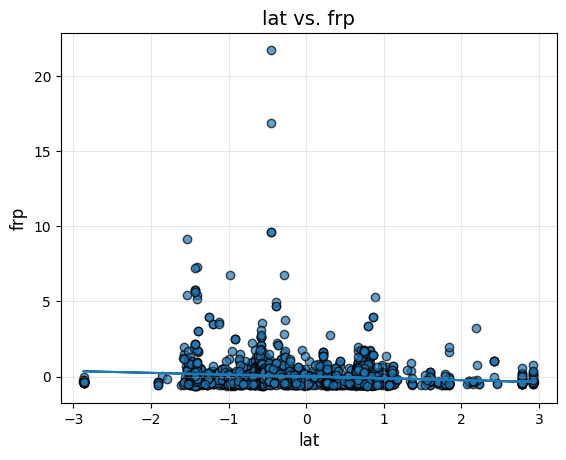

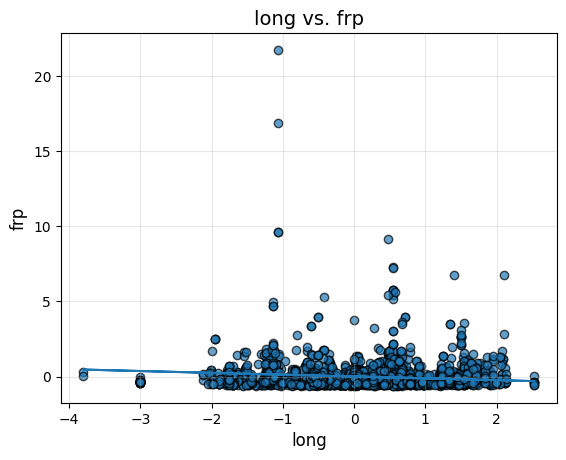

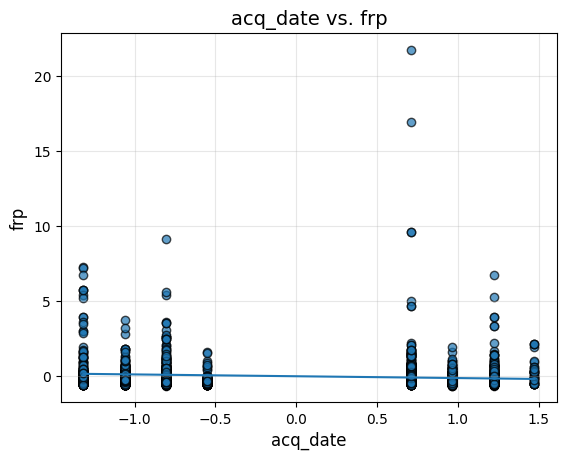

In [33]:
# PLOTS - lat, long, acq_date
print(f'Best-fit line: y = {round(m[0], 3)} + {round(m[1], 3)}x + {round(m[2], 3)}x + {round(m[3], 3)}x')
n = ['lat', 'long', 'acq_date']
for i in n:
    x_plot = X2[:,n.index(i) + 1]
    plt.scatter(x=x_plot, y=y, alpha=0.7, edgecolor='k')
    plt.plot(x_plot, m[0] + m[1]*x_plot + m[2]*x_plot + m[3]*x_plot)
    plt.title(f'{i} vs. frp', fontsize=14)
    plt.xlabel(f'{i}', fontsize=12)
    plt.ylabel('frp', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [34]:
# x_plot = np.sort(x_days)

# # PLOTS - scatterplot of frp vs acq_date with best-fit line
# plt.figure(figsize=(10, 6))
# plt.scatter(x=x_plot, y=y, alpha=0.7, edgecolor='k')
# plt.plot(x_plot, m[0] + m[1]*x_plot, color='red',
#     label=f'Best-fit line: y = {round(m[0], 3)} + {round(m[1], 3)}x') # Best-fit line
# plt.title('(acq_date+acq_time) vs. frp', fontsize=14)
# plt.xlabel('acq_date+acq_time', fontsize=12)
# plt.ylabel('frp', fontsize=12)
# plt.grid(alpha=0.3)
# plt.legend(fontsize=12)
# plt.show()

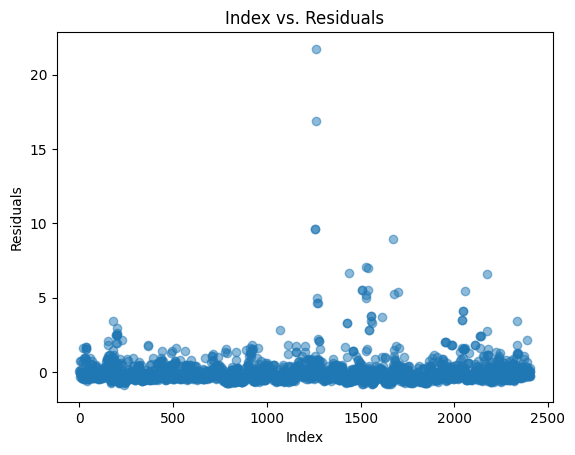

In [35]:
# index vs. residuals
plt.scatter(range(len(X2[:,1])), resids, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Index vs. Residuals')
plt.show()

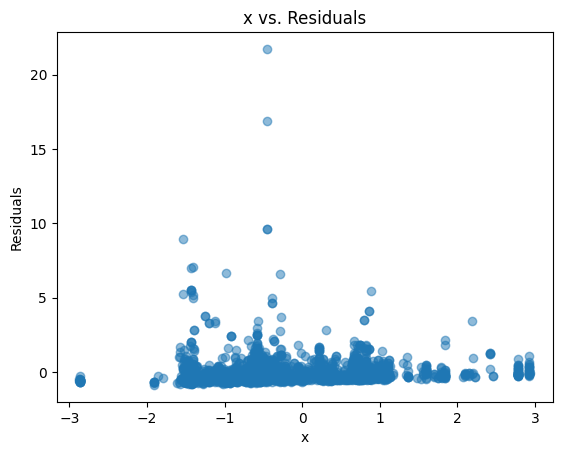

In [36]:
# acq_date+acq_time vs. residuals -- ONLY helpful acq_date + acq_time model
plt.scatter(X2[:,1], resids, alpha=0.5)
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('x vs. Residuals')
plt.show()

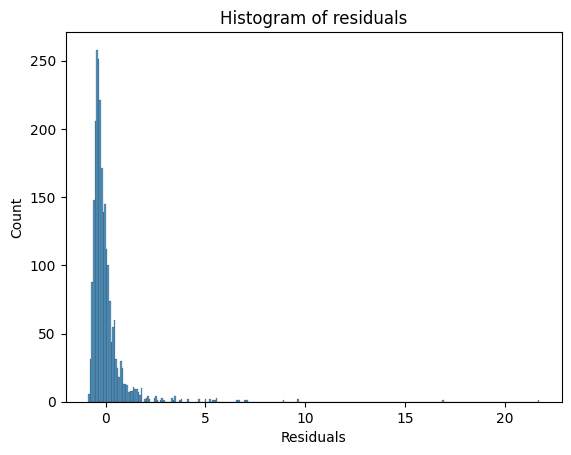

In [37]:
# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

In [38]:
# ORIGINAL LINEAR REGRESSION: acq_date vs. frq

# acq_date as the feature variable doesn't produce a good linear model

x_df = euro_c_df_clean['acq_date']
x_datetime = pd.to_datetime(x_df)
reference_date = pd.Timestamp(x_df.min())                       # earliest date, '2020-03-01'
x_timedelta = x_datetime - reference_date

# number of days between data collection and reference date
x_days = x_timedelta.dt.days

# scale data
x_days = (x_days - x_days.mean())/x_days.std()
frp=euro_c_df_clean['frp']
frp = (frp - frp.mean())/frp.std()

x = x_days.to_numpy()                                           # x: days since 2020-03-01
X = np.hstack([np.ones((x.shape[0], 1)), x.reshape(-1, 1)])     # X has a bias (1's) column
y = frp.to_numpy()                           # y: frp

# solves (X^T X) m = (X^T y) for m
m = np.linalg.solve(np.matmul(X.T, X), np.matmul(X.T, y))

# calculate predicted y's, residuals, squared residuals, and mse
ypreds = np.matmul(X, m)
resids = y - ypreds
new_r = []
for r in resids:
    new_r.append(r**2)
mse = sum(new_r) / len(new_r)
print('mse: ', mse)
r2 = 1 - (mse/y.var())
print('r^2: ', r2)

mse:  0.9983112178658664
r^2:  0.0012738564409227049


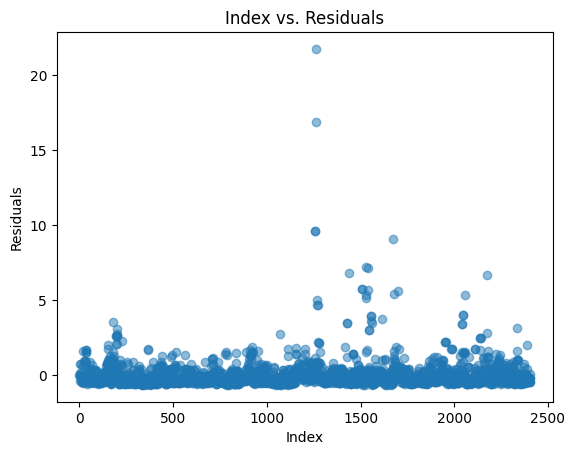

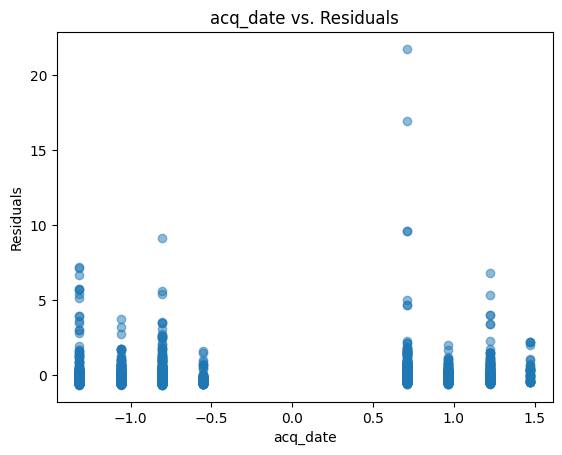

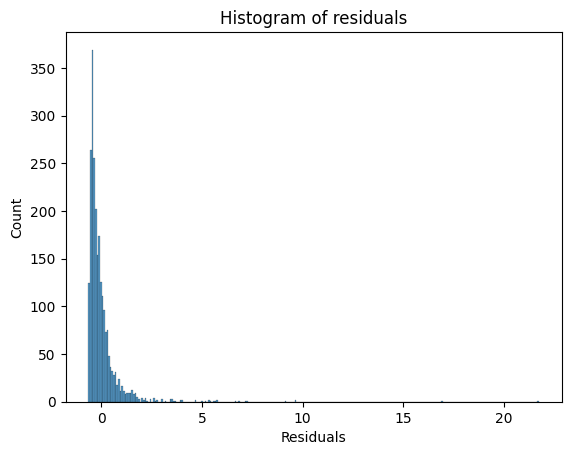

In [39]:
# index vs. residuals
plt.scatter(range(len(x)), resids, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Index vs. Residuals')
plt.show()

# acq_date+acq_time vs. residuals
plt.scatter(x, resids, alpha=0.5)
plt.xlabel('acq_date')
plt.ylabel('Residuals')
plt.title('acq_date vs. Residuals')
plt.show()

# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()